#**Maestría en Inteligencia Artificial Aplicada**
##**Advanced Machine Learning Methods (Gpo 10)**
###Tecnológico de Monterrey
###Profesor Ph.D. José Antonio Cantoral Ceballos

## **Activity 3a**

### Text Classification using RNNs and AG_NEWS dataset in PyTorch

##**Team 33**:

### Humberto Lozano Cedillo A01363184
### Julio Cesar Lynn Jimenez A01793660
### Sarah Mendoza Medina A01215352
### David Mireles Samaniego A01302935

## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [101]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [102]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

In [103]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [104]:
train_dataset, test_dataset = AG_NEWS()

In [105]:
test_dataset

ShardingFilterIterDataPipe

In [106]:
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [107]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [108]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [109]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [110]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [111]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [112]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [113]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [114]:
# Prepare the text processing pipeline with the tokenizer and vocabulary. 
# The text and label pipelines will be used to process the raw data strings from the dataset iterators.
text_pipeline = lambda x: vocab(tokeniser(x))
label_pipeline = lambda x: int(x) - 1

In [115]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))
    
    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [116]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [117]:
EMBEDDING_SIZE = 300
NEURONS = BATCH_SIZE
LAYERS = 2
NUM_CLASSES = 4

In [126]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), 
                                            embedding_dim=embed_size)
        
        self.rnn = nn.GRU(input_size= embed_size,
                            hidden_size=hidden,
                            num_layers=layers,
                            batch_first=True,
                            bidirectional=False # First train only one direction as a baseline   
                           ) 
                        
                        
        
        self.fc = nn.Linear(in_features=hidden, out_features=num_classes) 
      
        
    def forward(self, x):
        embedded = self.embedding_layer(x)
        y, h = self.rnn(embedded)
        return self.fc(y[:,-1]) # Only use output for last timestep. The reason is because this is a classification problem.
        

In [159]:
def accuracy(model, loader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (xi, yi) in enumerate(loader):
            xi = xi.to(device=device, dtype = torch.int32)
            yi = yi.to(device=device, dtype = torch.int32)
            
            predicted_label = model(xi)
            # loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == yi).sum().item()
            total_count += yi.size(0)
    return total_acc / total_count

In [128]:
epochs = 3
lr = 0.001
# instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [156]:
import time


def train_epoch(model, dataloader, optimiser, epoch):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (xi, yi) in enumerate(dataloader):
        xi = xi.to(device=device, dtype = torch.int32)
        yi = yi.to(device=device, dtype = torch.long) # Hast to be defined as long for the cross_entropy compatibility with target as class indices
    
        optimiser.zero_grad()
        scores = model(xi)
        _, pred = scores.max(dim=1)

        cost = F.cross_entropy(input=scores, target=yi)
        cost.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimiser.step()
        total_acc += (pred == yi).sum().item()
        total_count += yi.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

In [123]:
def train(model, optimiser, epochs):
    model = model.to(device)
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_epoch(model, train_loader, optimiser, epoch)
        accu_val = accuracy(model, val_loader)

        print("-" * 59)
        print(
            "| end of epoch {:3d} | time: {:5.2f}s | "
            "valid accuracy {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, accu_val
            )
        )
        print("-" * 59)

In [157]:
train(rnn_model, optimiser=optimiser,  epochs=epochs)

-----------------------------------------------------------
| end of epoch   1 | time: 28.18s | valid accuracy    0.895 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time: 26.55s | valid accuracy    0.915 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time: 28.79s | valid accuracy    0.915 
-----------------------------------------------------------


In [160]:
print(f'{accuracy(rnn_model, test_loader):.4f}')

0.9139


In [176]:
ag_news_label = {1: "World",
                 2: "Sports",
                 3: "Business",
                 4: "Sci/Tec"}

In [193]:
def predict(model, text):
    model.eval()
    x = [vocab(tokeniser(text))]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]
    xi = torch.tensor(x, dtype=torch.int32, device=device)

    with torch.no_grad():   
        predicted_label = model(xi)
        return predicted_label.argmax(1).item() + 1

In [194]:
def sample_text(model, loader):
    model = model.to(device)
    dataset = loader.dataset

    rnd_sample_idx = np.random.randint(len(dataset))
    (label, text) = dataset[rnd_sample_idx]
    print((ag_news_label[label], text))

    pred = predict(model, text)
    print(f'Predicted: {ag_news_label[pred]}')

In [197]:
sample_text(rnn_model, test_loader)

('Business', 'SEC Probes United Rentals, Shares Drop  CHICAGO (Reuters) - U.S. securities regulators are  investigating United Rentals Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=URI.N target=/stocks/quickinfo/fullquote"&gt;URI.N&lt;/A&gt; and have subpoenaed  some accounting records, the company said on Monday, sending  its shares down 21.5 percent.')
Predicted: Business


In [198]:
ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

pred = predict(rnn_model, ex_text_str)
print(f'Predicted: {ag_news_label[pred]}')


Predicted: World


In [233]:
# create confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, loader):
    model.eval()
    y_test = np.asarray([])
    y_predict = np.asarray([])

    with torch.no_grad():
        for idx, (xi, yi) in enumerate(loader):
            xi = xi.to(device=device, dtype = torch.int32)
            yi = yi.to(device=device, dtype = torch.int32)
            
            predicted_label = model(xi)

            y_test = np.concatenate((y_test, np.asarray(yi.to(device='cpu', dtype=int))), axis=None)
            y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=int)))), axis=None)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt = "d")
    print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      1900
         1.0       0.97      0.96      0.96      1900
         2.0       0.92      0.85      0.88      1900
         3.0       0.86      0.93      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.92      0.91      0.91      7600
weighted avg       0.92      0.91      0.91      7600



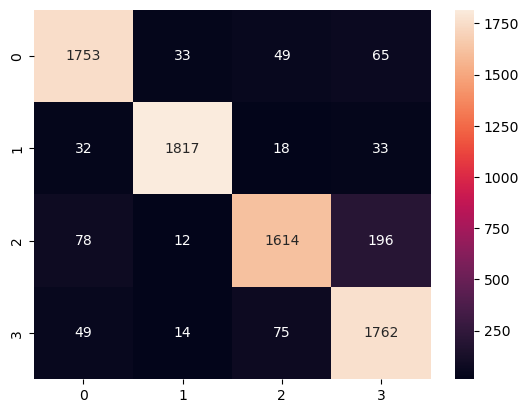

In [234]:
plot_confusion_matrix(rnn_model, test_loader)

# Bidirectional RNN model

In [199]:
class RNN_Model_2(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), 
                                            embedding_dim=embed_size)
        
        self.rnn = nn.GRU(input_size= embed_size,
                            hidden_size=hidden,
                            num_layers=layers,
                            batch_first=True,
                            bidirectional=True # First train only one direction as a baseline   
                           ) 
                        
        self.fc = nn.Linear(in_features=hidden*2, out_features=num_classes) # Double the size of hidden neurons to account for the reverse pass
        
    def forward(self, x):
        embedded = self.embedding_layer(x)
        y, h = self.rnn(embedded)
        return self.fc(y[:,-1]) # Only use output for last timestep. The reason is because this is a classification problem.

In [214]:
EMBEDDING_SIZE = 300
NEURONS = BATCH_SIZE
LAYERS = 3
NUM_CLASSES = 4

epochs = 5
lr = 0.001
# instantiate model
bidir_rnn_model = RNN_Model_2(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
bidir_optimiser = torch.optim.Adam(bidir_rnn_model.parameters(), lr=lr)

In [215]:
train(bidir_rnn_model, optimiser=bidir_optimiser, epochs=epochs)

-----------------------------------------------------------
| end of epoch   1 | time: 563.92s | valid accuracy    0.895 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time: 614.04s | valid accuracy    0.915 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time: 616.65s | valid accuracy    0.921 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time: 616.33s | valid accuracy    0.918 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time: 607.12s | valid accuracy    0.915 
-----------------------------------------------------------


In [216]:
torch.save(bidir_rnn_model, "bidir_rnn_model.h5")

In [217]:
print(f'{accuracy(bidir_rnn_model, test_loader):.4f}')

0.9121


In [222]:
sample_text(bidir_rnn_model, test_loader)

('Sci/Tec', 'Dell unveils holiday lineup, including new plasma TVs OCTOBER 15, 2004 (IDG NEWS SERVICE) - Dell Inc. took the wraps off its holiday lineup on Thursday, showing new printers, plasma televisions and music players that will soon be available through its Web site.')
Predicted: Sci/Tec


In [223]:
ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

pred = predict(bidir_rnn_model, ex_text_str)
print(f'Predicted: {ag_news_label[pred]}')

Predicted: Sports


              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91      1900
         1.0       0.97      0.97      0.97      1900
         2.0       0.89      0.87      0.88      1900
         3.0       0.89      0.88      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



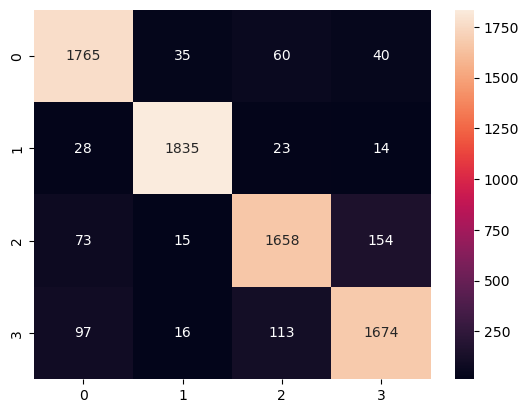

In [235]:
plot_confusion_matrix(bidir_rnn_model, test_loader)